In [2]:
#Importing necessary libraries
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import os
import librosa.display
from skimage.io import imread
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_text
from sklearn.inspection import permutation_importance


C:\Users\19147\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
import pandas as pd

# Load the CSV file
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
df = pd.read_csv(metadata_path)

# Display the first few rows of the dataframe 
df.head()


,id,genus,species,subspecies,name,recordist,country,location,latitude,longitude,altitude,sound_type,source_url,license,time,date,remarks,filename
0,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-0.wav
1,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-1.wav
2,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-4.wav
3,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-5.wav
4,557838,Thryomanes,bewickii,NaN,Bewick's Wren,Whitney Neufeld-Kaiser,United States,"Arlington, Snohomish County, Washington",48.0708,-122.1006,100,"adult, sex uncertain, song",//www.xeno-canto.org/557838,//creativecommons.org/licenses/by-nc-sa/4.0/,11:51,2020-03-14,"Recorded with Voice Record Pro on iPhone7, nor...",557838-6.wav


In [4]:
#distribution of species
species_dist = df['species'].value_counts()
print(species_dist)

species
melodia        1256
polyglottos    1182
cardinalis     1074
migratorius    1017
bewickii        893
Name: count, dtype: int64


In [5]:
# Checking for missing values in each column
missing_values = df.isnull().sum()
print(missing_values)

id               0
genus            0
species          0
subspecies    3876
name             0
recordist        0
country          0
location         0
latitude        90
longitude       90
altitude        42
sound_type       0
source_url       0
license          0
time             0
date             0
remarks       1859
filename         0
dtype: int64


The primary input for generating spectrograms is the audio file itself. Missing values in metadata (like subspecies, latitude, longitude, altitude, and remarks) won't affect the generation of spectrograms, as long as the audio files (filename) are intact and not missing. 

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5422 entries, 0 to 5421
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          5422 non-null   int64  
 1   genus       5422 non-null   object 
 2   species     5422 non-null   object 
 3   subspecies  1546 non-null   object 
 4   name        5422 non-null   object 
 5   recordist   5422 non-null   object 
 6   country     5422 non-null   object 
 7   location    5422 non-null   object 
 8   latitude    5332 non-null   float64
 9   longitude   5332 non-null   float64
 10  altitude    5380 non-null   object 
 11  sound_type  5422 non-null   object 
 12  source_url  5422 non-null   object 
 13  license     5422 non-null   object 
 14  time        5422 non-null   object 
 15  date        5422 non-null   object 
 16  remarks     3563 non-null   object 
 17  filename    5422 non-null   object 
dtypes: float64(2), int64(1), object(15)
memory usage: 762.6+ KB
None


**Feature Extraction**

In [7]:

def load_bird_sound_paths_from_csv(metadata_path, audio_files_path):
    df = pd.read_csv(metadata_path)
    file_paths = []
    labels = []

    for index, row in df.iterrows():
        file_path = os.path.join(audio_files_path, row['filename'])
        if os.path.exists(file_path):
            file_paths.append(file_path)
            labels.append(row['species'])  # 'species' holds the label
        else:
            print(f"File not found: {file_path}")

    return file_paths, labels

# Usage
metadata_path = "C:/Users/19147/Downloads/archive (12)/bird_songs_metadata.csv"
audio_files_path =  "C:/Users/19147/Downloads/archive (12)/wavfiles"

file_paths, labels = load_bird_sound_paths_from_csv(metadata_path, audio_files_path)
print(file_paths[:5], labels[:5])


['C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-0.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-1.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-4.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-5.wav', 'C:/Users/19147/Downloads/archive (12)/wavfiles\\557838-6.wav'] ['bewickii', 'bewickii', 'bewickii', 'bewickii', 'bewickii']


In [20]:
# New function to load and process audio files from paths
def load_and_process_audio(file_paths, sr, fixed_length):
    processed_audio = []
    for file_path in file_paths:
        sound, _ = librosa.load(file_path, sr=sr)
        if len(sound) > fixed_length:
            sound = sound[:fixed_length]
        else:
            padding = fixed_length - len(sound)
            sound = np.pad(sound, (0, padding), 'constant')
        processed_audio.append(sound)
    return processed_audio

In [24]:
def extract_combined_features(file_path, sr):
    # Load the audio file first
    audio, sr = librosa.load(file_path, sr=sr)
    
    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    # Extract Log Mel Spectrogram features
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    log_mel_spec = librosa.power_to_db(mel_spec)
    log_mel_spec_mean = np.mean(log_mel_spec, axis=1)

    # Extract waveform features: RMS and ZCR
    rms = librosa.feature.rms(y=audio).flatten()
    zcr = librosa.feature.zero_crossing_rate(y=audio).flatten()

    # Combine all features
    combined_features = np.concatenate((mfcc_mean, log_mel_spec_mean, rms, zcr))
    return combined_features


In [27]:
sr = 22050  
features_list = [extract_combined_features(fp, sr) for fp in file_paths]
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the dataset into training and testing sets
X3_train, X3_test, y3_train, y3_test, files_train, files_test = train_test_split(
    features_list, encoded_labels, file_paths, test_size=0.2, random_state=42
)

Accuracy: 0.8294930875576036
Classification Report:
              precision    recall  f1-score   support

    bewickii       0.79      0.75      0.77       193
  cardinalis       0.82      0.84      0.83       204
     melodia       0.74      0.86      0.80       243
 migratorius       0.92      0.88      0.90       207
 polyglottos       0.91      0.80      0.85       238

    accuracy                           0.83      1085
   macro avg       0.84      0.83      0.83      1085
weighted avg       0.84      0.83      0.83      1085



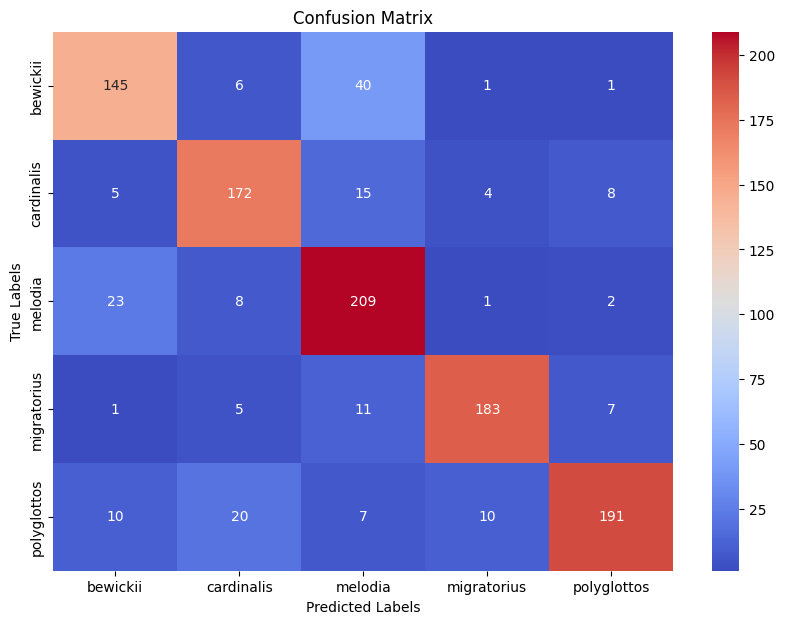

In [28]:
clf_combined = RandomForestClassifier(random_state=42)
clf_combined.fit(X3_train, y3_train)


Combined_predictions = clf_combined.predict(X3_test)

# Print accuracy and classification report
print("Accuracy:", accuracy_score(y3_test, Combined_predictions))
print("Classification Report:")
print(classification_report(y3_test, Combined_predictions, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, Combined_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [39]:

# Calculate probabilities and find maximum confidence predictions
probs = clf_combined.predict_proba(X3_test)
max_probs = np.max(probs, axis=1)

# Top 10, bottom 10, and incorrect indices
top_10_indices = np.argsort(-max_probs)[:10]
print("top 10 indices:",top_10_indices)
bottom_10_indices = np.argsort(max_probs)[:10]
print("bottom_10_indices:", bottom_10_indices)
incorrect_indices = np.where(Combined_predictions != y3_test)[0]
print("incorrect indices:",incorrect_indices)

top 10 indices: [409 328 714  14 861  85 492 854  24 278]
bottom_10_indices: [ 974  486  361  710 1015  674  184 1003 1067  603]
incorrect indices: [   5    8   27   34   35   49   56   57   61   67   68   78   79   82
  100  102  106  109  110  122  129  132  135  136  141  145  151  156
  158  162  166  173  176  179  182  184  188  190  191  192  198  201
  204  205  206  221  231  236  246  270  271  277  282  287  290  295
  299  307  324  330  331  333  334  336  342  346  361  370  383  388
  391  398  404  406  410  412  413  418  437  442  448  452  454  455
  467  472  476  486  493  500  507  513  515  522  532  543  558  570
  572  575  576  579  586  587  588  590  603  606  609  611  622  624
  638  641  650  658  659  660  662  665  674  677  680  683  685  705
  707  710  713  724  727  729  747  750  753  754  762  769  778  779
  787  788  795  804  813  819  824  825  833  851  862  864  878  888
  889  890  893  911  923  927  932  946  948  954  958  962  969  974


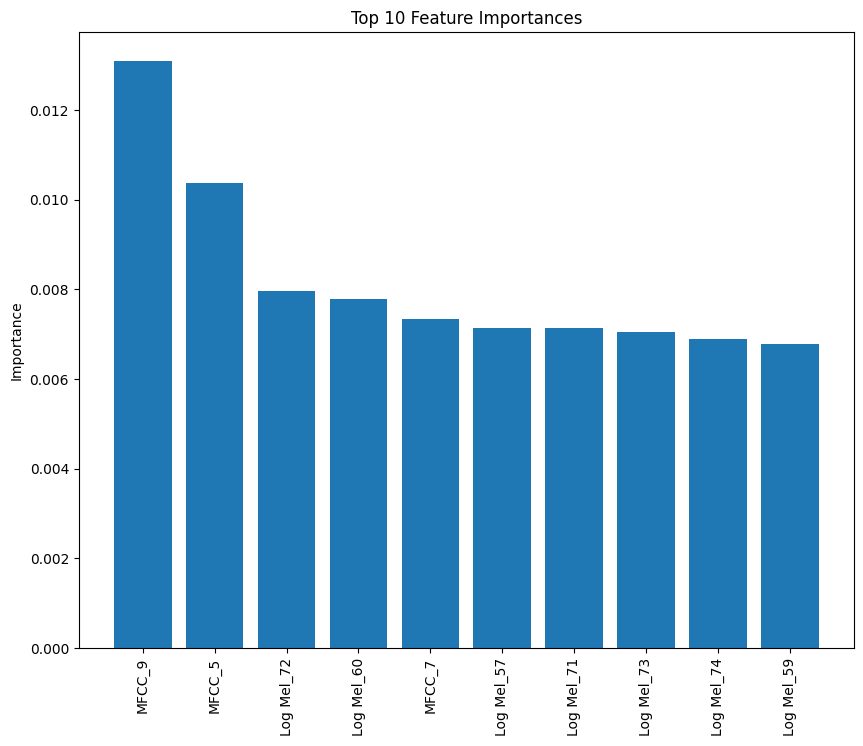

In [50]:

feature_names = ['MFCC_{}'.format(i) for i in range(13)] + \
                ['Log Mel_{}'.format(i) for i in range(128)] + \
                ['RMS', 'ZCR']

importances = clf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  

# Plotting top N features
N = 10
plt.figure(figsize=(10, 8))
plt.bar(range(N), importances[indices[:N]], align='center')
plt.xticks(range(N), [feature_names[i] for i in indices[:N]], rotation=90)
plt.title('Top 10 Feature Importances')
plt.ylabel('Importance')
plt.show()
